In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 19 - Number concept development

## 19.1 Knower-level model for Give-N


$$ \pi \sim \text{Dirichlet}\overbrace{(1,...,1)}^{15} $$
$$ \nu \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime}_{ijk} \propto
\begin{cases}
\pi_k & \text{if $k \gt z_i$} \\
\nu \times \pi_{ijk} & \text{if $k \leq z_i$ and $k = q^g_{ij}$} \\
\frac{1}{\nu} \times \pi_{ijk} & \text{if $k \leq z_i$ and $k \neq q^g_{ij}$}
\end{cases}  $$  
$$ a_{ij}^g \sim \text{Categorical}(\pi^{\prime}_{ij})$$

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/fc_given.mat')

ns = np.squeeze(np.int64(matdata['ns']))
nz = np.squeeze(np.int64(matdata['nz']))
gnq = np.squeeze(np.int64(matdata['gnq']))
gn = np.squeeze(np.int64(matdata['gn']))
ga = np.squeeze(np.int64(matdata['ga']))
gq = np.squeeze(np.int64(matdata['gq']))

ind1=np.zeros((nz,gn,gn))
ind2=np.zeros((nz,gn,gn))
ind3=np.zeros((nz,gn,gn))
ind4=np.zeros((nz,gn,gn))
ind5=np.zeros((nz,gn,gn),dtype=int)
for i in range(nz):
    for j in range(gn):
        for k in range(gn):
            # Will be 1 if Knower-Level (i.e, i-1) is Same or Greater than Answer
            ind1[i,j,k] = np.greater_equal(i-1,k)
            # Will be 1 for the Possible Answer that Matches the Question
            ind2[i,j,k] = k==j
            # Will be 1 for 0-Knowers
            ind3[i,j,k] = i==0
            # Will be 1 for HN-Knowers
            ind4[i,j,k] = i==nz
            ind5[i,j,k] = ind3[i,j,k]+ind4[i,j,k]*(2+ind2[i,j,k]) 
            + (1-ind4[i,j,k])*(1-ind3[i,j,k])* (ind1[i,j,k]+ind1[i,j,k]*ind2[i,j,k]+1)

I am not able to make this work in pymc3, currently it is unusable (1, takes forever to complie to sample in NUTS; 2, after very long compling it can sample using Metropoli but the catigorical node is not been sample properly). Use pymc2 instead

In [3]:
import theano

# To avoide max recusion limit error in Theano
import sys 
sys.setrecursionlimit(50000)

index = theano.shared(ind5)

with pm.Model() as model1:
    pi = pm.Dirichlet("pi",a=np.ones(15),shape=15)
    nu = pm.Uniform("nu",lower=1,upper=1000)
    
    zi = pm.Categorical("zi",p=np.ones(nz)/nz,shape=ns)
#     zi = pm.DiscreteUniform("zi",lower=0,upper=nz,shape=ns)
    
    ##### v3 #####
#     aij=[]
#     for z in range(ns):
#         # m = theano.tensor.cast(T.clip(zi[z],0,nz-1), 'int64')
#         for j in range(gnq[z]):
#             piprime = theano.shared(np.zeros(gn))
#             for k in range(gn):
#                 lk = theano.tensor.cast(index[zi[z],gq[z,j]-1,k], 'int64')
#                 piprimetmp = T.stack([pi[k],pi[k]/nu,nu*pi[k]])
#                 piprime = T.set_subtensor(piprime[k],piprimetmp[lk])
#             i=z*int(21)+j
#             obtmp=ga[z,j]-1
#             aij.append([pm.Categorical("aij_%i"%i,p=piprime/T.sum(piprime),observed=obtmp)])
    
    
    ##### v2 #####
    def logp(p, k, value):
        sumto1 = theano.gradient.zero_grad(T.le(abs(T.sum(p) - 1), 1e-5))
        return pm.dist_math.bound(T.log(p[value]),value >= 0, value <= (k - 1),sumto1)
    def CatelikeMat(observed,index):
        lp_is = theano.shared(np.zeros(ns))
        for i in range(ns):
            lp_parts = 0
            m = theano.tensor.cast(T.clip(zi[i],0,nz-1), 'int64')
            for j in range(gnq[i]):
                v = theano.tensor.cast(gq[i,j]-1, 'int64')
                
                piprime = theano.shared(np.zeros(gn))
                for k in range(gn):
                    lk = theano.tensor.cast(index[m,v,k], 'int64')
                    piprimetmp = T.stack([pi[k],1/nu*pi[k],nu*pi[k]])
                    piprime = T.set_subtensor(piprime[k],piprimetmp[lk])
                        
                o = theano.tensor.cast(observed[i,j]-1, 'int64')
                lp_parts+=logp(p=piprime/T.sum(piprime),k=15,value=o)
            lp_is = T.set_subtensor(lp_is[i],lp_parts)
        return T.sum(lp_is)
    
    aij = pm.DensityDist('aij', CatelikeMat, observed={'observed':ga,'index':ind5})
    
    ##### v1 #####
#     npiprime = theano.shared(np.zeros((nz,gn,gn)))
#     for z in range(nz):
#         for j in range(gn):
#             piprime = theano.shared(np.zeros(gn))
#             for k in range(gn):
#                 piprimetmp = T.stack([pi[k],1/nu*pi[k],nu*pi[k]])
#                 piprime = T.set_subtensor(piprime[k],piprimetmp[ind5[z,j,k]])
#             npiprime = T.set_subtensor(npiprime[z,j,:],piprime/T.sum(piprime))

#     aij = []
#     for z in range(ns):
#         for j in range(gnq[z]):
#             i=z*int(21)+j
#             obtmp=ga[z,j]-1
#             aij.append([pm.Categorical("aij_%i"%i,p=npiprime[zi[z],gq[z,j]-1,:],observed=obtmp)])

    step1=pm.ElemwiseCategoricalStep(vars=[zi], values=np.arange(nz))
    step2=pm.Metropolis(vars=[pi,nu])
    trace1=pm.sample(3e3,step=[step1,step2])

pm.traceplot(trace1)
plt.show()

Applied stickbreaking-transform to pi and added transformed pi_stickbreaking to model.
Applied interval-transform to nu and added transformed nu_interval to model.


In [ ]:
import pymc as pymc
pi = pymc.Dirichlet("pi",theta=np.ones(15+1))
nu = pymc.Uniform("nu",lower=1,upper=1000)
    
zi = pymc.Categorical("zi",p=np.ones(nz)/nz,size=ns)

def pifunc(pi=pi,nu=nu):
    npiprime = np.zeros((nz,gn,gn))
    for z in range(nz):
        for j in range(gn):
            piprime = np.zeros(gn)
            for k in range(gn):
                piprimetmp = [pi[k],1/nu*pi[k],nu*pi[k]]
                piprime[k]=piprimetmp[ind5[z,j,k]]
            npiprime[z,j,:]=piprime/np.sum(piprime)
    return npiprime
npiprime = pymc.Deterministic(eval = pifunc,
                  name = 'npiprime',
                  parents = {'pi': pi,
                          'nu': nu},
                  doc = 'npiprime',
                  trace = False,
                  verbose = 0,
                  dtype=float,
                  plot=False)

for z in range(ns):
    for j in range(gnq[z]):
        i=z*int(21)+j
        obtmp=ga[z,j]-1
        aij=pymc.Container([pymc.Categorical("aij_%d"%i,p=npiprime[zi[z],gq[z,j]-1,:],value=obtmp,observed = True)])
        
testmodel = pymc.Model([pi,nu,zi,aij])
mcmc = pymc.MCMC(testmodel)
mcmc.sample(iter = 3e5, burn = 500, thin = 2)
pymc.Matplot.plot(mcmc)

 [                  1%                  ] 3020 of 300000 complete in 54.0 sec

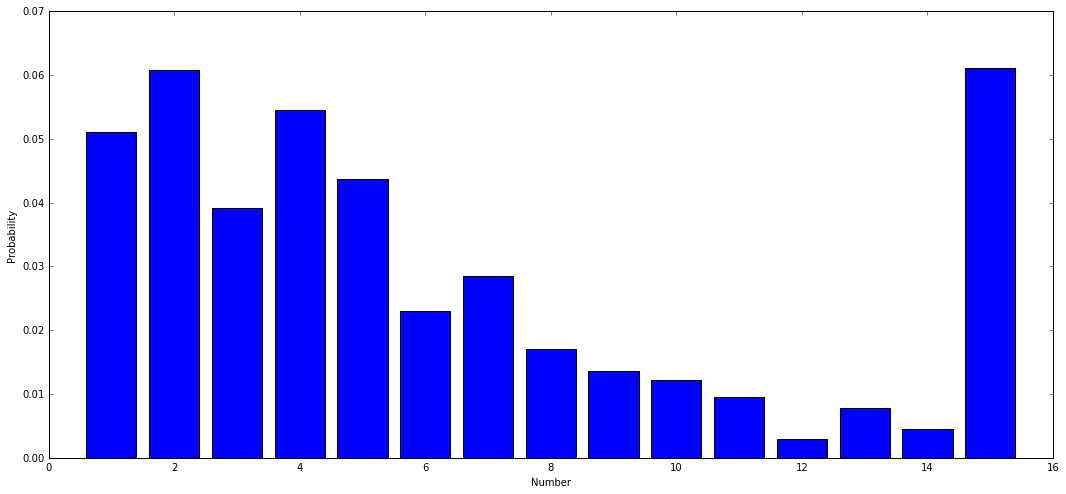

In [47]:
pitr=mcmc.trace("pi")[:]
fig = plt.figure(figsize=(18, 8))
plt.bar(np.arange(15)+1,np.mean(pitr,axis=0),align='center')
plt.xlabel('Number')
plt.ylabel('Probability')
plt.xlim([0,16])
plt.show()

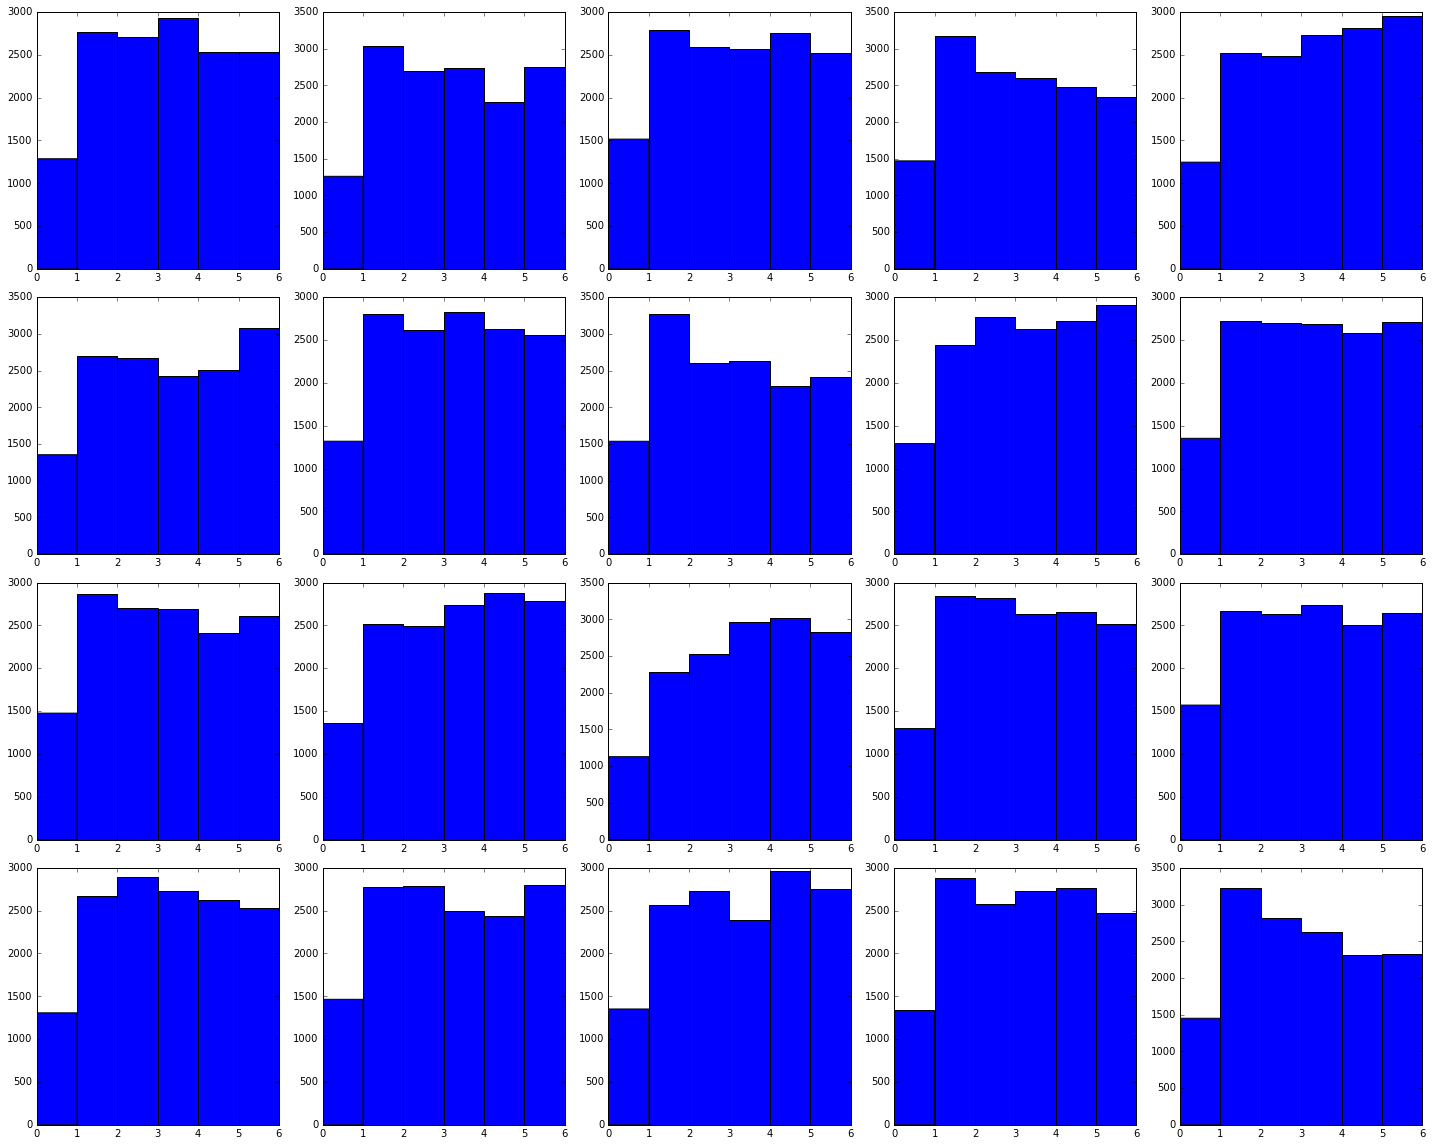

In [48]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4,5)
zitr=mcmc.trace("zi")[:]#trace1['zi']
for i in range(ns):
    ax = plt.subplot(gs[i])
    ax.hist(zitr[:,i],bins=np.arange(nz+1))
plt.tight_layout()
plt.show()

## 19.2 Knower-level model for Fast-Cards


$$ \pi \sim \text{Dirichlet}\overbrace{(1,...,1)}^{50} $$
$$ \nu \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime}_{ijk} \propto
\begin{cases}
\pi_k & \text{if $k \gt z_i$} \\
\nu \times \pi_{ijk} & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu} \times \pi_{ijk} & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  
$$ a_{ij}^f \sim \text{Categorical}(\pi^{\prime}_{ij})$$

## 19.3 Knower-level model for Give-N and Fast-Cards


$$ \pi^{g} \sim \text{Dirichlet}\overbrace{(1,...,1)}^{15} $$
$$ \pi^{f} \sim \text{Dirichlet}\overbrace{(1,...,1)}^{50} $$
$$ \nu^{g},\nu^{f} \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime g}_{ijk} \propto
\begin{cases}
\pi_k^g & \text{if $k \gt z_i$} \\
\nu^g \times \pi_{ijk}^g & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu^g} \times \pi_{ijk}^g & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  

$$ \pi^{\prime f}_{ijk} \propto
\begin{cases}
\pi_k^f & \text{if $k \gt z_i$} \\
\nu^f \times \pi_{ijk}^f & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu^f} \times \pi_{ijk}^f & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  

$$ a_{ij}^g \sim \text{Categorical}(\pi^{\prime g}_{ij})$$
$$ a_{ij}^f \sim \text{Categorical}(\pi^{\prime f}_{ij})$$